# **DEMO: CRNN-Mb, a Multibranch CNN-RNN for ESC**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/MLHD_labs/Project_backup/Final_proj'

/content/drive/MyDrive/MLHD_labs/Project_backup/Final_proj


In [3]:
pip install pydub

In [4]:
from data_helper import *
from plot_utils import *
from preprocess import *
from train_test_model import *
import numpy as np
import tensorflow as tf
import pickle
import gc
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="white", palette="muted")

import pandas as pd
import random
random.seed(20150420)


In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **DEMO**
Here I show a small demo of how the Variant C of the model works for a small sample of the test dataset.    
Specifically, I test the model on three classes separately:
1. The *washing_machine* class, on which every model struggled;
2. The *siren* class, which has an accuracy of approximately $50\%$ for all models;
3. The *pouring_water* class, on which each model reached $100\%$ accuracy.
To select these specific classes from the test dataset, here I will manually select and preprocess the data.

In [5]:
with open("test_50.pkl", "rb") as f:
    test = pickle.load(f)
with open("classes.pkl", "rb") as c:
    classes = pickle.load(c)

In [6]:
machine_clips = []
siren_clips = []
water_clips = []

for clip in test:
  if clip.category=='washing_machine':
    machine_clips.append(clip)
  elif clip.category=='siren':
    siren_clips.append(clip)
  elif clip.category=='pouring_water':
    water_clips.append(clip)

In [7]:
print('Test samples of class washing_machine: {0}\nTest samples of class siren: {1}\nTest samples of class pouring water: {2}\n'.format(len(machine_clips), len(siren_clips), len(water_clips)))

Test samples of class washing_machine: 10
Test samples of class siren: 10
Test samples of class pouring water: 10



In [8]:
# Create one-hot encoded labels. create_labels_array function works by looking at unique classes in the provided dataset, so it first needs to be applied to the whole 50-class dataset
y_test = create_labels_array(test)

# retrieve indices for selected labels, so we can filter out y_test
machine = np.argwhere([c=='washing_machine' for c in classes])[0][0]
siren = np.argwhere([c=='siren' for c in classes])[0][0]
water = np.argwhere([c=='pouring_water' for c in classes])[0][0]
print(machine, siren, water)

47 40 35


In [9]:
y_machine = y_test[y_test[:, machine] == 1]
y_siren = y_test[y_test[:, siren] == 1]
y_water = y_test[y_test[:, water] == 1]

In [10]:
# If mode='test', the segmentation function returns clips id instead of folds
architecture = 'multibranch'
mode = 'test'
cnn_machine, rnn_machine, labels_machine, ids_machine = segmentation(machine_clips, y_machine, architecture, mode)
cnn_siren, rnn_siren, labels_siren, ids_siren = segmentation(siren_clips, y_siren, architecture, mode)
cnn_water, rnn_water, labels_water, ids_water = segmentation(water_clips, y_water, architecture, mode)

# Check shapes
print('Washing_machine class:\nShape of CNN Input:{}, Shape of RNN Input:{}\n'.format(cnn_machine.shape, rnn_machine.shape))
print('Siren class:\nShape of CNN Input:{}, Shape of RNN Input:{}\n'.format(cnn_siren.shape, rnn_siren.shape))
print('Pouring_water class:\nShape of CNN Input:{}, Shape of RNN Input:{}'.format(cnn_water.shape, rnn_water.shape))

Washing_machine class:
Shape of CNN Input:(30, 60, 101, 2), Shape of RNN Input:(30, 101, 13)

Siren class:
Shape of CNN Input:(30, 60, 101, 2), Shape of RNN Input:(30, 101, 13)

Pouring_water class:
Shape of CNN Input:(30, 60, 101, 2), Shape of RNN Input:(30, 101, 13)


In [11]:
# Load model
model_c = tf.keras.models.load_model("cnn2d_rnn_multibranch_32_1000_T.h5")
model_c.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_cnn_2D (InputLayer) │ (None, 60, 101, 2)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_1 (Conv2D)        │ (None, 60, 101, 80)    │         54,800 │ Input_cnn_2D[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 60, 101, 80)    │            320 │ 2D_Conv_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 60, 101, 80)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 34, 80)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 34, 80)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_2 (Conv2D)        │ (None, 60, 34, 80)     │         19,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 60, 34, 80)     │            320 │ 2D_Conv_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 60, 34, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 60, 12, 80)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_rnn (InputLayer)    │ (None, 101, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 12, 80)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │          9,024 │ Input_rnn[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57664)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)      

 Total params: 58,799,796 (224.30 MB)

 Trainable params: 58,799,474 (224.30 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

## 6.1 Class 47: *washing_machine*

In [12]:
# From clips_labels (the one-hot encoded labels associated to each of the 500 original clips), extract an array with the number of the corresponding class
Y_true = np.argmax(y_machine, axis=1)

# Prepare test dataset for testing
batch_size = 32
test_dataset = tf.data.Dataset.from_tensor_slices(((cnn_machine, rnn_machine), labels_machine)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
# Predict
predictions = model_c.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [14]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_machine = aggregate_predictions(predictions, ids_machine)

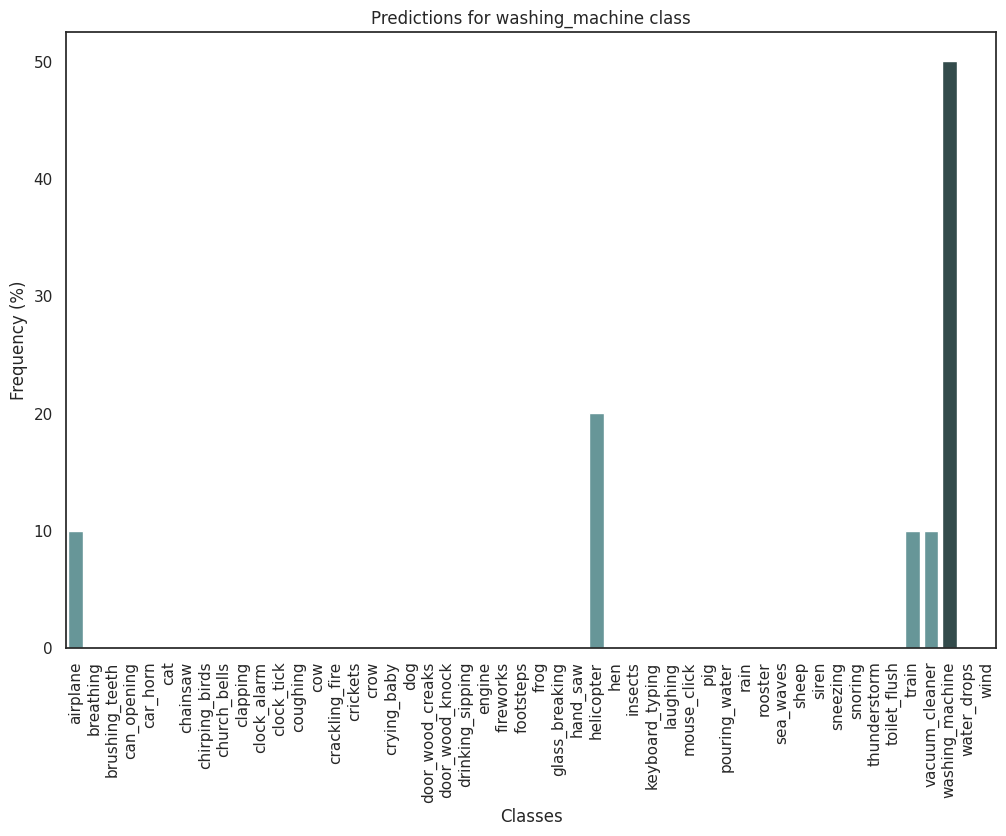

In [17]:
# Count occurrences of each index
class_counts = Counter(Y_pred_machine)
total_count = len(Y_pred_machine)

# Extract class names and corresponding frequencies (normalized to percentage)
classes_id = list(class_counts.keys())
frequencies = [(class_counts[i] / total_count * 100) if i in class_counts else 0 for i in range(len(classes))]

# Define colors (highlight class 47)
colors = ["darkslategray" if c==47 else "cadetblue" for c in range(len(classes))]

# Plot
plt.figure(figsize=(12, 8))
sb.barplot(x=classes, y=frequencies, palette=colors)

# Labels and title
plt.xlabel("Classes")
plt.ylabel("Frequency (%)")
plt.title("Predictions for washing_machine class")
plt.xticks(rotation=90)  # Rotate class labels for readability

plt.show()

## 6.2 Class 40: *siren*

In [18]:
# From clips_labels (the one-hot encoded labels associated to each of the 500 original clips), extract an array with the number of the corresponding class
Y_true = np.argmax(y_siren, axis=1)

# Prepare test dataset for testing
batch_size = 32
test_dataset = tf.data.Dataset.from_tensor_slices(((cnn_siren, rnn_siren), labels_siren)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
predictions = model_c.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [21]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_siren = aggregate_predictions(predictions, ids_siren)

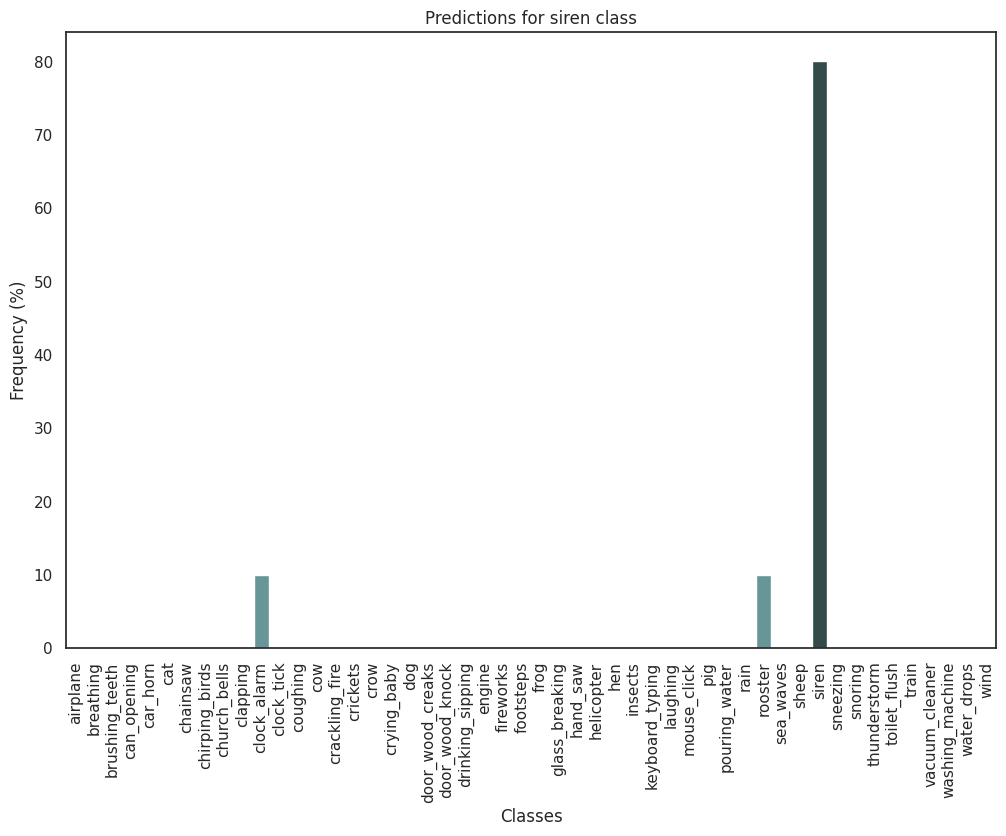

In [22]:
# Count occurrences of each index
class_counts = Counter(Y_pred_siren)
total_count = len(Y_pred_siren)

# Extract class names and corresponding frequencies (normalized to percentage)
classes_id = list(class_counts.keys())
frequencies = frequencies = [(class_counts[i] / total_count * 100) if i in class_counts else 0 for i in range(len(classes))]

# Define colors (highlight class 40)
colors = ["darkslategray" if c == 40 else "cadetblue" for c in range(len(classes))]

# Plot
plt.figure(figsize=(12, 8))
sb.barplot(x=classes, y=frequencies, palette=colors)

# Labels and title
plt.xlabel("Classes")
plt.ylabel("Frequency (%)")
plt.title("Predictions for siren class")
plt.xticks(rotation=90)  # Rotate class labels for readability

plt.show()

## 6.3 Class 35: *pouring_water*

In [23]:
# From clips_labels (the one-hot encoded labels associated to each of the 500 original clips), extract an array with the number of the corresponding class
Y_true = np.argmax(y_water, axis=1)

# Prepare test dataset for testing
batch_size = 32
test_dataset = tf.data.Dataset.from_tensor_slices(((cnn_water, rnn_water), labels_water)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [24]:
predictions = model_c.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [25]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_water = aggregate_predictions(predictions, ids_water)

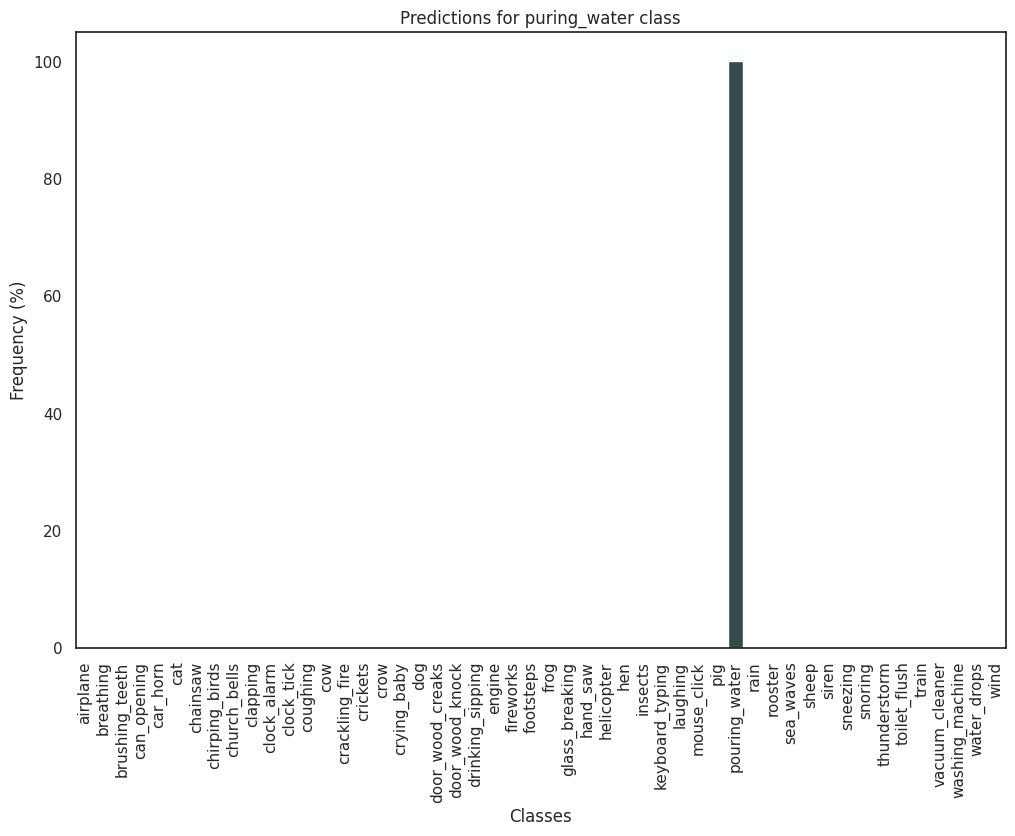

In [26]:
# Count occurrences of each index
class_counts = Counter(Y_pred_water)
total_count = len(Y_pred_water)

# Extract class names and corresponding frequencies (normalized to percentage)
classes_id = list(class_counts.keys())
frequencies = [(class_counts[i] / total_count * 100) if i in class_counts else 0 for i in range(len(classes))]

# Define colors (highlight class 35)
colors = ["darkslategray" if c == 35 else "cadetblue" for c in range(len(classes))]

# Plot
plt.figure(figsize=(12, 8))
sb.barplot(x=classes, y=frequencies, palette=colors)

# Labels and title
plt.xlabel("Classes")
plt.ylabel("Frequency (%)")
plt.title("Predictions for puring_water class")
plt.xticks(rotation=90)  # Rotate class labels for readability

plt.show()